In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Бутстреп для оценки стандартного отклонения 90% квантиля

In [3]:
n = 1000            # размер исходной выборки
B = 1000            # количество генерируемых подвыборок

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))

std = np.std(bootstrap_quantiles)
print(f'Оценка 90% квантиля: {quantile:0.2f}')
print(f'Оценка std для 90% квантиля: {std:0.2f}')

Оценка 90% квантиля: 116.69
Оценка std для 90% квантиля: 1.32


### Построение доверительного интервала с помощью бутстрапа

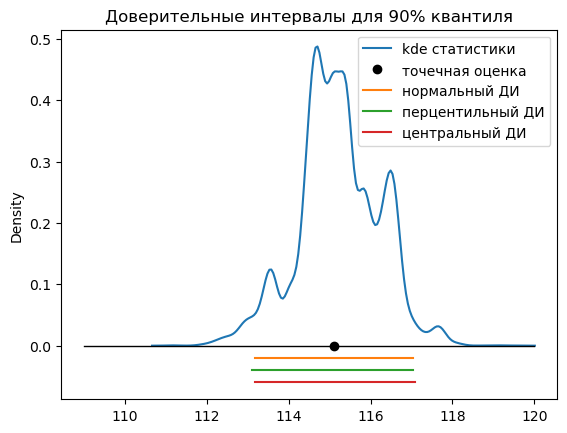

In [4]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """Нормальный доверительный интервал"""
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Перцентильный доверительный интервал"""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """Центральный доверительный интервал"""
    left, right= 2 * pe - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right

n = 1000
B = 10000
alpha = 0.05

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = np.quantile(np.random.choice(values, (B, n), True), 0.9, axis=1)

normal_ci = get_normal_ci(bootstrap_quantiles, quantile, alpha)
percentile_ci = get_percentile_ci(bootstrap_quantiles, quantile, alpha)
pivotal_ci = get_pivotal_ci(bootstrap_quantiles, quantile, alpha)

sns.kdeplot(bootstrap_quantiles, label='kde статистики')
plt.plot([quantile], [0], 'o', c='k', markersize=6, label='точечная оценка')
plt.plot([109, 120], [0, 0], 'k', linewidth=1)
d = 0.02
plt.plot(normal_ci, [-d, -d], label='нормальный ДИ')
plt.plot(percentile_ci, [-d*2, -d*2], label='перцентильный ДИ')
plt.plot(pivotal_ci, [-d*3, -d*3], label='центральный ДИ')

plt.title('Доверительные интервалы для 90% квантиля')
plt.legend()
plt.show()

### Проверка статистических гипотез с помощью бутстрапа

In [5]:
n = 1000
B = 10000
alpha = 0.05

values_a = np.random.normal(90, 20, n)
values_b = np.random.normal(90, 15, n)

pe = np.quantile(values_b, 0.9) - np.quantile(values_a, 0.9)
bootstrap_values_a = np.random.choice(values_a, (B, n), True)
bootstrap_metrics_a = np.quantile(bootstrap_values_a, 0.9, axis=1)
bootstrap_values_b = np.random.choice(values_b, (B, n), True)
bootstrap_metrics_b = np.quantile(bootstrap_values_b, 0.9, axis=1)
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
ci = get_percentile_ci(bootstrap_stats, pe, alpha)
has_effect = not (ci[0] < 0 < ci[1])

print(f'Значение 90% квантиля изменилось на: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение 90% квантиля изменилось на: -4.71
95.0% доверительный интервал: (-7.62, -2.25)
Отличия статистически значимые: True


### Корректность проведения АВ теста с помощью бутстрапа

In [6]:
def estimate_sample_size(effect, std, alpha, beta) -> int:
  t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
  t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
  var = 2 * std ** 2
  sample_size = int((t_alpha + t_beta) ** 2 * var / effect ** 2)
  return sample_size


def run_synthetic_experiments(mean: int, effect: int, std: int, alpha: float,
                              n: int, B: int, n_iters: int) -> list:
  has_effect = []
  for _ in range(n_iters):
    values_a = np.random.normal(mean, std, n)
    values_b = np.random.normal(mean+effect, std, n)
    pe = np.quantile(values_b, 0.9) - np.quantile(values_a, 0.9) # считаем бутстрам метрику для 90% квантиля

    bootstrap_a = np.random.choice(values_a, (B, n), True)
    bootstrap_b = np.random.choice(values_b, (B, n), True)

    bootstrap_a_metrics = np.quantile(bootstrap_a, 0.9, axis=1)
    bootstrap_b_metrics = np.quantile(bootstrap_b, 0.9, axis=1)
    bootstrap_stats = bootstrap_b_metrics - bootstrap_a_metrics

    percentile_ci = get_percentile_ci(bootstrap_stats, pe, alpha)
    has_effect.append(not percentile_ci[0] < 0 < percentile_ci[1])
  return has_effect

In [8]:
B = 1000
n_iters = 500
alpha = 0.05
beta = 0.2
mean = 90
std = 5
effect = 2.5

sample_size = estimate_sample_size(effect, std, alpha, beta)
n = sample_size * 3

bootstrap_aa = run_synthetic_experiments(mean, 0, std, alpha, n, B, n_iters)
bootstrap_ab = run_synthetic_experiments(mean, effect, std, alpha, n, B, n_iters)

print(f'bootstrap_aa = {np.mean(bootstrap_aa)}')
print(f'bootstrap_ab = {np.mean(bootstrap_ab)}')

bootstrap_aa = 0.046
bootstrap_ab = 0.812
